In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:
df = pd.read_csv("DiamondsPrices.csv")

This dataset has diamond prices and a number of different types of features for the diamonds.
It's a pretty clean dataset. I'll try to fit a regression model to predict the price from the features

In [4]:
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [5]:
df.shape

(53940, 10)

# Price vs. Carat 

Carat should be the most important feature influencing price

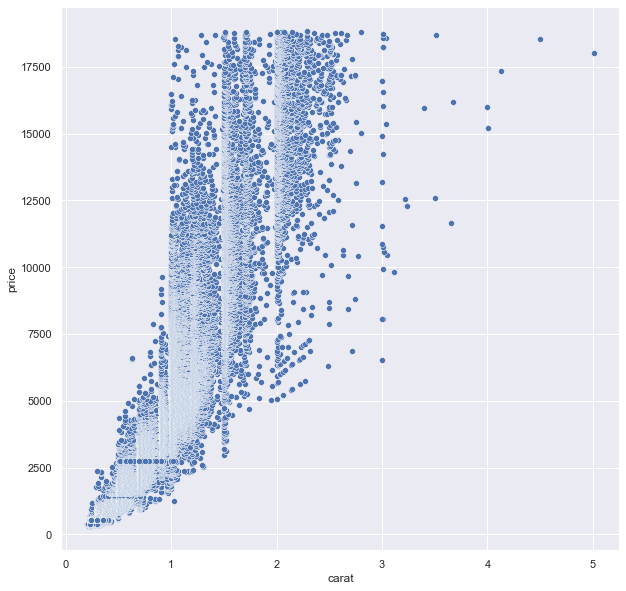

In [6]:
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(data=df,x='carat',y='price')
plt.show()

There is a relationship here, but carat does not completely determine price. You can see verticle and horizontal bands are several carats (ex: verticals at ~1, ~1.5 suggesting for same carats, there is a significant variation in price) same horizontal bands (ex: ~2500, same price for a range of diamonds of different carats). Other features are definitely important

In [13]:
num_cols = df.select_dtypes(include=np.number).columns.tolist()
cat_cols = df.select_dtypes(include='O').columns.tolist()
num_cols.remove('price')

# Fixing the Categorical Columns
Cut, clarity and color are the 3 categorical types of data. Doing some research on them, we can convert them to a linear scale
This should help us avoid doing a OneHotEncoding

#### Cut
Cut can be made into a linear scale: <br>
{'Ideal':1., 'Premium':4., 'Very Good':3., 'Good':2., 'Fair':0.}

#### Clarity
Clarity should also be a linear scale: (a little research gave us this: <br>
{'I1':0.,'SI2':1.,'SI1':2.,'VS2':3.,'VS1':4.,'VVS2':5.,'VVS1':6.,'IF':7.} <br>
IF - internally flawless (highest grade), VVS1, VVS2 (very very small inclusions), VS1, VS2 (very small inclusions),
SI1, SI2 (small inclusions), I1 - inclusions

#### Color
Color (some research gave us this): <br>
{'J':0.,'I':1.,'H':2.,'G':3.,'F':4.,'E':5.,'D':6.} <br>
D being most colorless and J being least colorless

In [8]:
enc_cut = {'Ideal':1./4, 'Premium':4./4, 'Very Good':3./4, 'Good':2./4, 'Fair':0./4}
df['cut'] = df['cut'].replace(enc_cut)

enc_clarity = {'I1':0./7,'SI2':1./7,'SI1':2./7,'VS2':3./7,'VS1':4./7,'VVS2':5./7,'VVS1':6./7,'IF':7./7}
df['clarity'] = df['clarity'].replace(enc_clarity)

enc_color = {'J':0./6,'I':1./6,'H':2./6,'G':3./6,'F':4./6,'E':5./6,'D':6./6}
df['color'] = df['color'].replace(enc_color)

# Visualizing the Numerical Columns

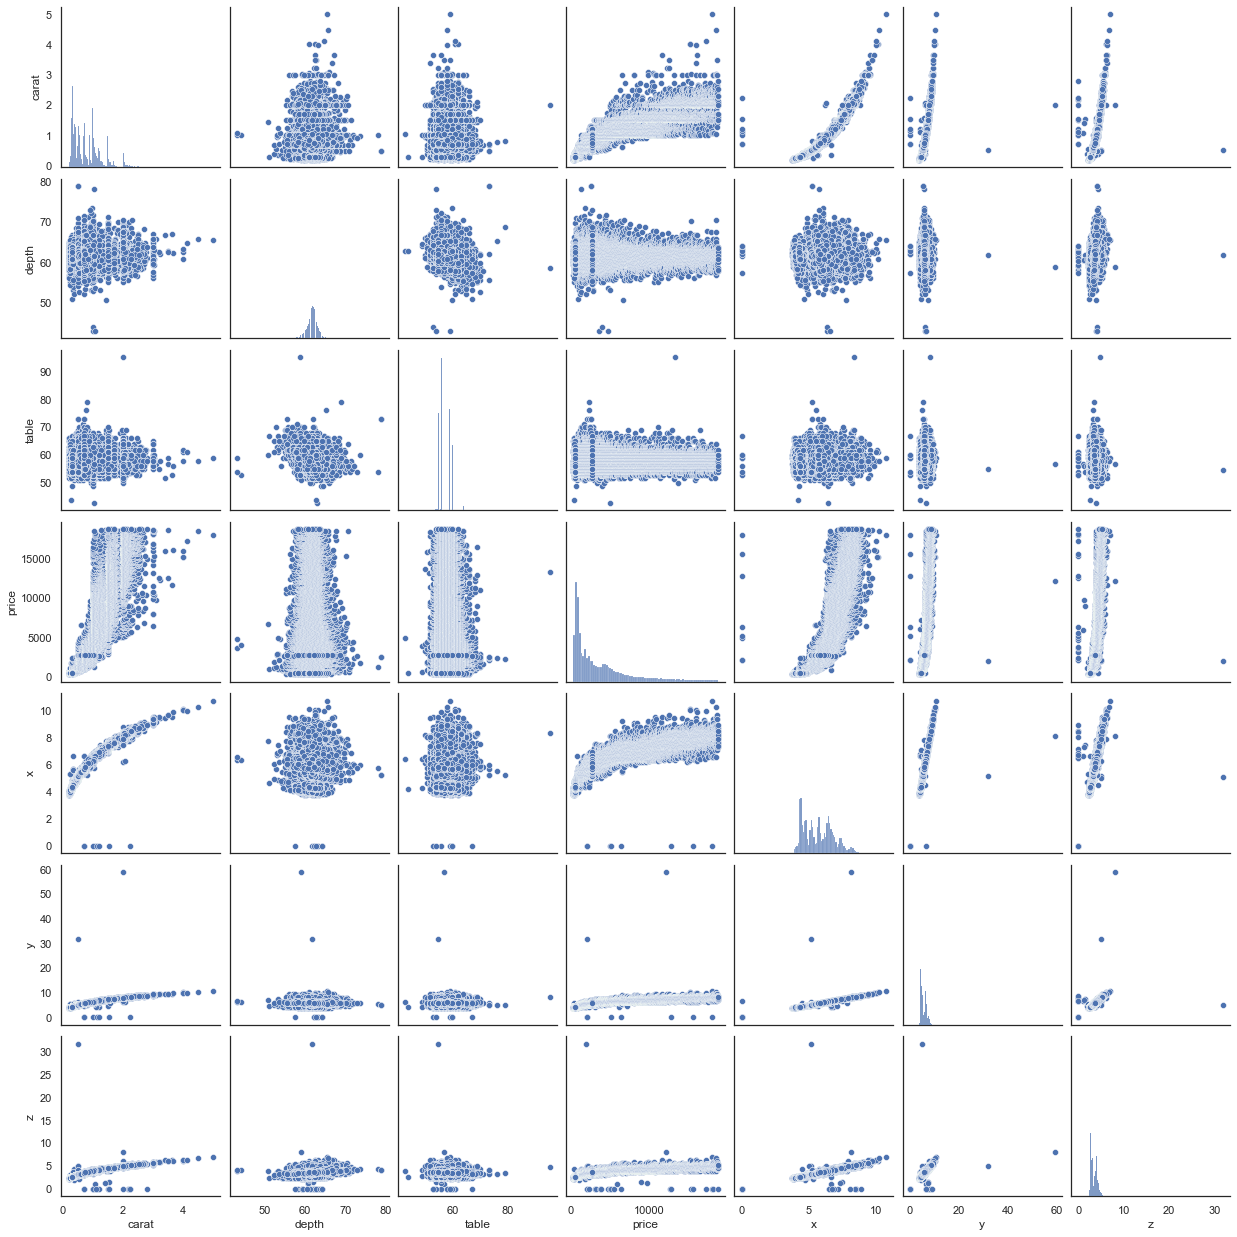

In [33]:
sns.pairplot(df)
plt.show() 
#this pairplot is amongst the features excluding cut, clarity and color
#it looks like carat, x (y and z less so) should be important features. 
#depth and table don't seem to have much predictive value

# Preparing the Data for Model Fitting
The numerical columns have skewed distributions. We'll do a power transform on them

In [14]:
from sklearn.preprocessing import MinMaxScaler, PowerTransformer
from sklearn.model_selection import train_test_split

trainX, testX, y_train, y_test = train_test_split(df.drop(['price'],axis=1),df['price'],test_size=0.2,random_state=2)

scaler = PowerTransformer()
scaler.fit(trainX[num_cols])
trainX[num_cols] = scaler.transform(trainX[num_cols])
testX[num_cols] = scaler.transform(testX[num_cols])

# Model Fitting

In [15]:
from sklearn.metrics import r2_score

from sklearn.linear_model import LinearRegression, Ridge, Lasso, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

C:\Users\dasab\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [16]:
regressors = [LinearRegression(), Ridge(), Lasso(), SGDRegressor(),
              DecisionTreeRegressor(),
              CatBoostRegressor(verbose=False), XGBRegressor(), LGBMRegressor()]

scores = pd.DataFrame(columns=['Regressor','Test-R2','Train-R2'])

for i in regressors:
    i.fit(trainX, y_train)
    y_pred_test = i.predict(testX)
    y_pred_train = i.predict(trainX)
    r2test = r2_score(y_test,y_pred_test)
    r2train = r2_score(y_train,y_pred_train)
    scores.loc[len(scores.index)] = [i.__class__.__name__,r2test,r2train]

C:\Users\dasab\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [17]:
scores.sort_values(by='Test-R2') 
#pretty good. catboost, lgbm and xgb performing like champs. And this is without any tuning

,Regressor,Test-R2,Train-R2
0,LinearRegression,0.788279,0.785950
1,Ridge,0.788312,0.785950
2,Lasso,0.788996,0.785916
3,SGDRegressor,0.789446,0.785753
4,DecisionTreeRegressor,0.966738,0.999995
6,XGBRegressor,0.981371,0.991376
7,LGBMRegressor,0.981940,0.985895
5,CatBoostRegressor,0.982537,0.988232


# Feature Importances

In [30]:
#catboost
print("\nFeature Importance for Catboost")
feat = np.flip(np.argsort(regressors[5].get_feature_importance())).tolist()
print(trainX.columns[feat].tolist())

#LGBM
print("\nFeature Importance for LGBM")
feat = np.flip(np.argsort(regressors[7].feature_importances_)).tolist()
print(trainX.columns[feat].tolist())

#XGB
print("\nFeature Importance for XGBoost")
feat = np.flip(np.argsort(regressors[6].feature_importances_)).tolist()
print(trainX.columns[feat].tolist())

#color and clarity are in top 3 in all 3 models


Feature Importance for Catboost
['carat', 'x', 'clarity', 'y', 'z', 'color', 'depth', 'cut', 'table']

Feature Importance for LGBM
['clarity', 'color', 'carat', 'y', 'depth', 'z', 'x', 'table', 'cut']

Feature Importance for XGBoost
['y', 'carat', 'clarity', 'color', 'z', 'cut', 'x', 'depth', 'table']
